In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mp

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

from ml.visualization import plot_confusion_matrix, classifier_boundary

np.random.seed(1234)  # Setup seed to be more deterministic\n",


import pandas as pd

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
def regresion_lineal(xtf,yt,xvf,yv,regularizacion,alpha,feature):
    if regularizacion==False:
        model = LinearRegression()
        model.fit(xtf, yt)
    else:
        model = Ridge(alpha=alpha)
        model.fit(xtf, yt)
 
    err_train = mean_squared_error(yt, model.predict(xtf))
    err_val = mean_squared_error(yv, model.predict(xvf)) 
        
    return [feature,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def regresion_polinomial(xtf,yt,xvf,yv,grado_polinomio,regularizacion,alpha,feature):
    poly_features = PolynomialFeatures(grado_polinomio)
    poly_features.fit(xtf)
    X_poly_train = poly_features.transform(xtf)
    X_poly_val = poly_features.transform(xvf)
    
    if regularizacion==False:
        model = LinearRegression()
        model.fit(X_poly_train, y_train)

    else:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train, y_train)        

    err_train = mean_squared_error(y_train, model.predict(X_poly_train))
    err_val = mean_squared_error(y_val, model.predict(X_poly_val))
    
    return [feature,grado_polinomio,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def modelo(x,coef,x0):
    ymodel = np.zeros(len(x))
    for i in range(len(x)):
        if len(coef)==1:
            ymodel[i] = coef[0]*x[i]
        else:
            for c in range(len(coef)):
                ymodel[i] = ymodel[i] + coef[c]*x[i]**c
    return ymodel+x0


def plot_fit(feature_resultados,tipo,c,lw):    
    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])

    X_linspace = np.linspace(X_range_start, X_range_stop, 200)
    
    # Conjunto de entrenamiento
    plt.scatter(X_train_feature, y_train, facecolor="lightgray", edgecolor="gray", label="datos",s=4.8)
    if tipo=='L':
        for j in range(len(feature_resultados)):
            coef = feature_resultados.Coef.values[j]
            x0 = feature_resultados.Intercept.values[j]
            plt.plot(X_linspace, modelo(X_linspace,coef,x0), color=c, label="modelo",lw=lw)
            plt.title("Conjunto de Entrenamiento Reg-Lin")
    elif tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            for j in range(len(sub_df)):
                coef = sub_df.Coef.values[j]
                x0 = sub_df.Intercept.values[j]
                plt.plot(X_linspace, modelo(X_linspace,coef,x0),color=c[cc],label="modelo",lw=1)
                plt.title("Conjunto de Entrenamiento Reg-Pol")
            cc+=1
            
    plt.ylim(y_range_start, y_range_stop)
    
    # Conjunto de validación
    #plt.subplot(1, 2, 2)
    #plt.scatter(X_val_feature, y_val, facecolor=\"dodgerblue\", edgecolor=\"k\", label=\"datos\")
    #plt.plot(X_linspace, model.predict(X_linspace_poly), color=\"tomato\", label=\"modelo\")
    #plt.ylim(y_range_start, y_range_stop)
    #plt.title(\"Conjunto de Validación\")
    
def plot_err(feature_resultados,Err,tipo,c):
    if tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            if Err=='T':
                plt.plot(sub_df.Alpha,sub_df.TrainMSE,color=c[cc],label='Grado: '+str(g))
            elif Err=='V':
                plt.plot(sub_df.Alpha,sub_df.ValMSE,color=c[cc],label='Grado: '+str(g))
            cc+=1                
        plt.legend(loc='lower right',frameon=False,ncol=3)
    elif tipo=='L':
        if Err=='T':
            plt.plot(feature_resultados.Alpha,feature_resultados.TrainMSE,color=c)
        elif Err=='V':
            plt.plot(feature_resultados.Alpha,feature_resultados.ValMSE,color=c)
    plt.xlabel('alpha')
    plt.ylabel('ECM')
    
def plot_err_g(feature_resultados,Err,c):
    if Err=='T':
        plt.plot(feature_resultados.Degree,feature_resultados.TrainMSE,color=c,label='ENTRENAMIENTO')              
    elif Err=='V':
        plt.plot(feature_resultados.Degree,feature_resultados.ValMSE,color=c,label='VALIDACION',ls='--')
    plt.xlabel('Degree')
    plt.ylabel('ECM')
    plt.legend(frameon=False,loc='upper left')

In [6]:
boston_data = load_boston()

In [8]:
regresion_lineal_ECM = pd.DataFrame(columns=['Feature','Regularization','Alpha','TrainMSE', 'ValMSE','Coef','Intercept'])
regresion_polinomial_ECM = pd.DataFrame(columns=['Feature','Degree','Regularization','Alpha','TrainMSE','ValMSE','Coef','Intercept'])


shuff_data = np.random.permutation(506)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = boston_data['data'][shuff_train]
X_val = boston_data['data'][shuff_val]

y_train = boston_data['target'][shuff_train]
y_val = boston_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(boston_data['feature_names'])}

features = boston_data['feature_names']
categorical_features = ['CHAS','RAD','MEDV']
non_categorical_features = set(features)-set(categorical_features)

#alpha = np.arange(0.1, 1.1, 0.1)
grado = np.arange(1,10,1)
alpha = np.arange(1e-5,1e3,10)

cmap = mp.cm.get_cmap('Spectral')
color = []
for i in range(len(grado)):
    color.append(cmap(0.1*i))

for feature in non_categorical_features:
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    # regresion lineal
    ## sin regularizacion
    row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,False,0,feature)
    
    regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    ## con regularizacion
    for i in alpha:
        row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,True,i,feature)
        regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    

    # regresion polinomial
    ## sin regularizacion
    for g in grado:
        row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,False,0,feature)
        regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)
    ## con regularizacion
        for i in alpha:
            row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,True,i,feature)
            regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)
  

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.8919e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.85156e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.85156e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.70313e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.55469e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.0259e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.04455e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.0632e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.08186e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.10051e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.09073e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.2808e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.47087e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.66093e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.851e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/ana

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.20127e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.21914e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.23701e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.25489e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.27276e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.64868e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.82882e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.00896e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.18913e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.3693e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.33937e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.35744e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37553e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.39361e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.41169e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.30903e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.49259e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.6762e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.85987e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.04359e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.53561e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.55555e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.57549e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.59544e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.61538e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.33769e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.54213e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.74657e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.95101e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.15545e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.77864e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.79909e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.81953e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.83997e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.86042e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.11422e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.29057e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.46692e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.64327e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.81962e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.02835e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.06381e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.09928e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13474e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.1702e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.97868e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.01414e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.0496e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.08506e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.12052e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.00578e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.08092e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.15607e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.23121e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.30636e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.21387e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.28902e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.36416e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.43931e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.6303e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.59413e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.75606e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.91799e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.07992e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.24184e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.19253e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.54717e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.90181e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.25645e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.61109e-40): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.30528e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.34074e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.37621e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.41167e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.44714e-39): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.57687e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.65571e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.73455e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.8134e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.89224e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.9921e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.07094e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.14978e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.22863e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.30747e-45): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.87583e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.04997e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.22411e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.39824e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.57238e-51): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.44534e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.46275e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.48016e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.49758e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.51499e-50): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.60142e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.76576e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.93009e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.09443e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.25877e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.36399e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.38043e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.39686e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.41329e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.42973e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.27066e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.47262e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.67458e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.87654e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.07851e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.76751e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.78585e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.8042e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.82255e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.84089e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.65193e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.86698e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.0082e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.02971e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.05122e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.10652e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.12809e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.14966e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.17122e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.81864e-38): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.21962e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24443e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.26924e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.29406e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.31889e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.79884e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.551e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13064e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.40649e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.68265e-35): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.74135e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.77359e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.80584e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.83809e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.87034e-34): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.37053e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.14617e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.43882e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.43882e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.87764e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.76246e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.90634e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.05023e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.19411e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.33799e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.35336e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.63618e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.919e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.20183e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.48465e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.20601e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.23429e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.26257e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.29085e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.31914e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37188e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.42675e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.48163e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.5365e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.59138e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.5205e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.56722e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.61395e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.6607e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.70745e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.3228e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.41131e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.49989e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.58855e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.67728e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.3749e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.46642e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.55801e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.64966e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.74136e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.46733e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.63927e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.81157e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.98422e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.15722e-32): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.47492e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.49512e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.51532e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.53553e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.55573e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.47952e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.79449e-24): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.7945e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.24466e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.80698e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.15827e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.25638e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.35448e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.45258e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.55069e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.47482e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.57292e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.67103e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.76913e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.86723e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.3365e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.47394e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.61138e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.74883e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.88627e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.6944e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.80319e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.912e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.02083e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.12967e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/ana

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.67192e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.56255e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.45319e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13438e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.32345e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.03404e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.18642e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.33898e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.4917e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.64461e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.35926e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.66439e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.6644e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.50682e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.50682e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.02807e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.07314e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.1182e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.16327e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.20834e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.966e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.01107e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.05614e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.1012e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.14627e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/ana

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.34981e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37681e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.40381e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.4308e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.4578e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.51065e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.53765e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.56465e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.59164e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.61864e-25): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.66573e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.82923e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.99274e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.15624e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.31974e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.55329e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.56964e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.58599e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.60234e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.61869e-30): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.7874e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.88718e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.98697e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.08675e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.18653e-36): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.12392e-49): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.12393e-43): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.22478e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.83718e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.44957e-42): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.57205e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.63329e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.69453e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.75576e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.817e-41): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.54969e-48): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.13245e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.50994e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.88742e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.26491e-47): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.30266e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.3404e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.37815e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.4159e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.45365e-46): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.30262e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.68102e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.05979e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.43894e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.81846e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.79756e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.8406e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.88363e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.92667e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.96971e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.52824e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.90937e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.02905e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.06716e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.10528e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.08715e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.12526e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.16338e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.20149e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.2396e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.33747e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37009e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.40272e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.43534e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.46796e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.43331e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.14996e-28): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.08666e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.35833e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.62999e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.94686e-27): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.01648e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.03829e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.06009e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.08191e-26): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.86405e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.19662e-19): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.41316e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.6581e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.26738e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.40099e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.55105e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.70104e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.85098e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.00085e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.73215e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.8466e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.31738e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.2733e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.55698e-17): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/an

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.40319e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.47065e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.53811e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.60556e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.67302e-18): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.41204e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.81811e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.2257e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.63478e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.04532e-22): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.60257e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.74895e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.89543e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.04202e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.18872e-21): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.59992e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.61659e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.63325e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.64992e-20): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.62393e-31): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.37899e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.4094e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.43966e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.47002e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.50038e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.71273e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.7431e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.77347e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.80375e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.83399e-23): result may not be accurate.
  overwrite_a=True).T
/home/meugenia/a

AGE


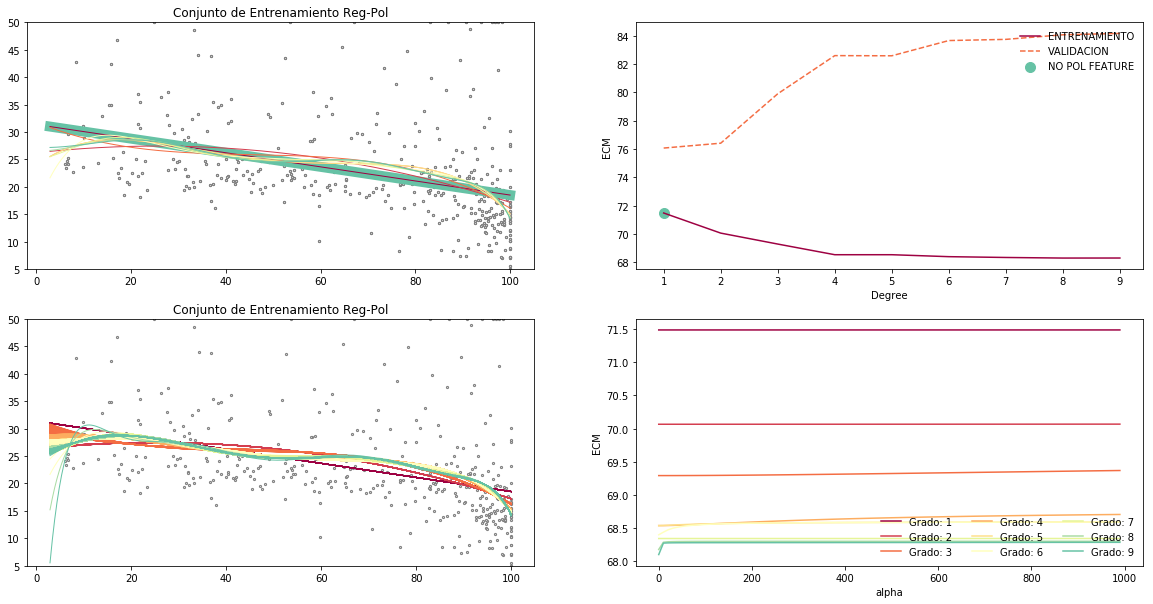

TAX


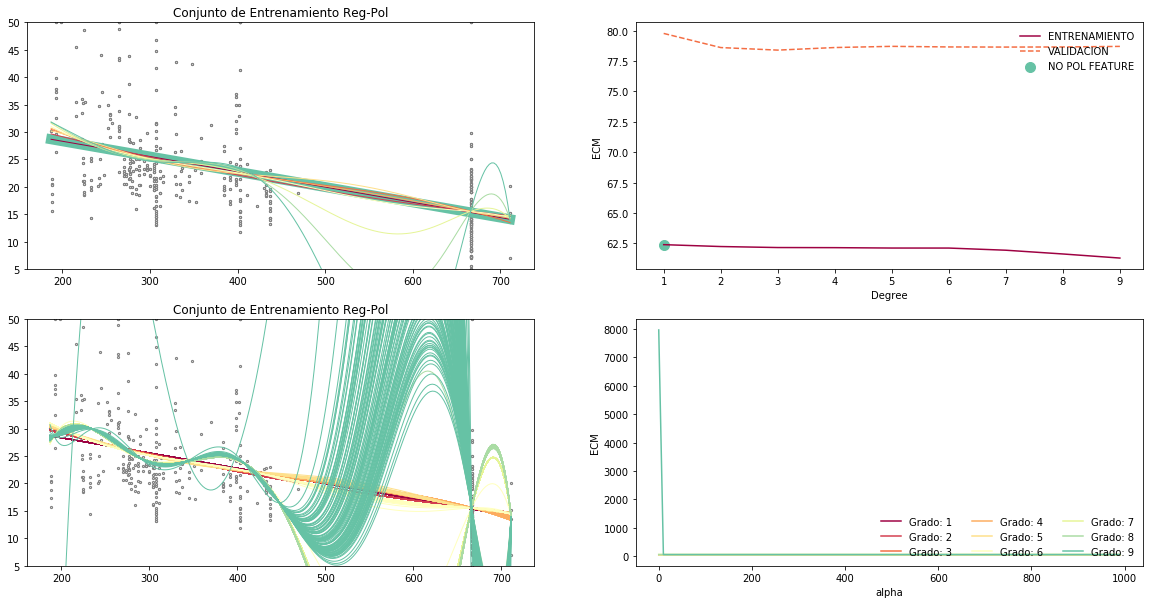

ZN


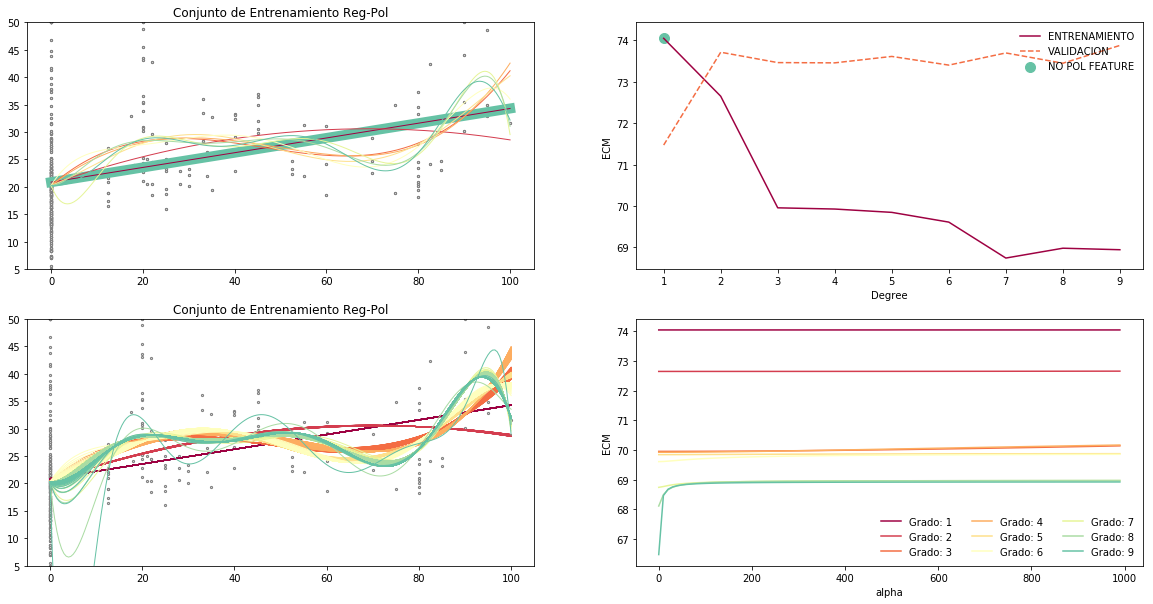

CRIM


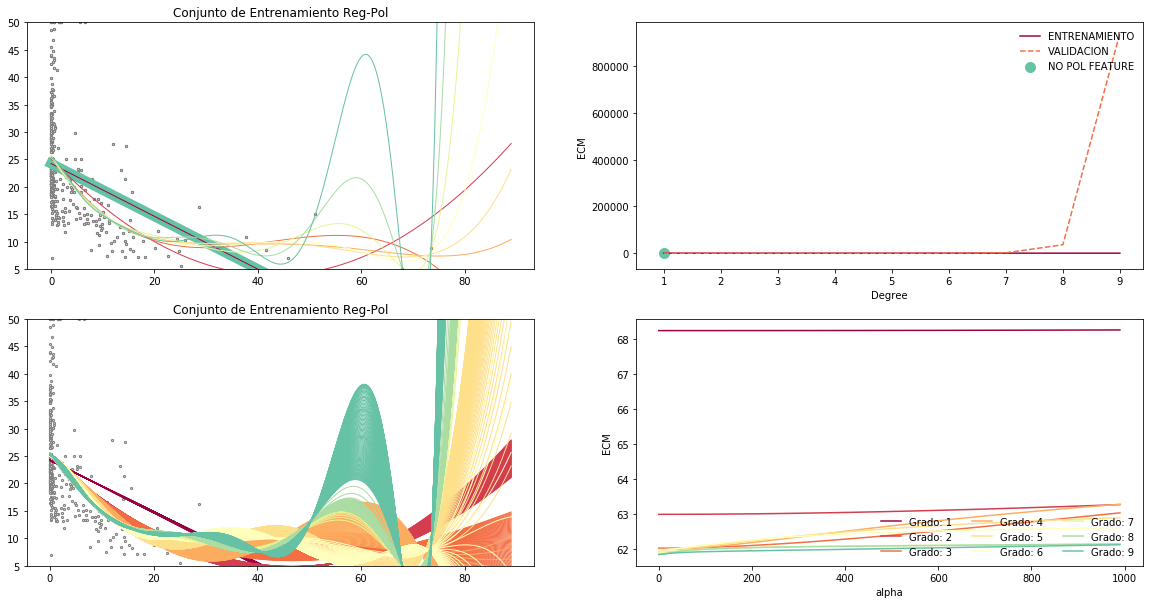

NOX


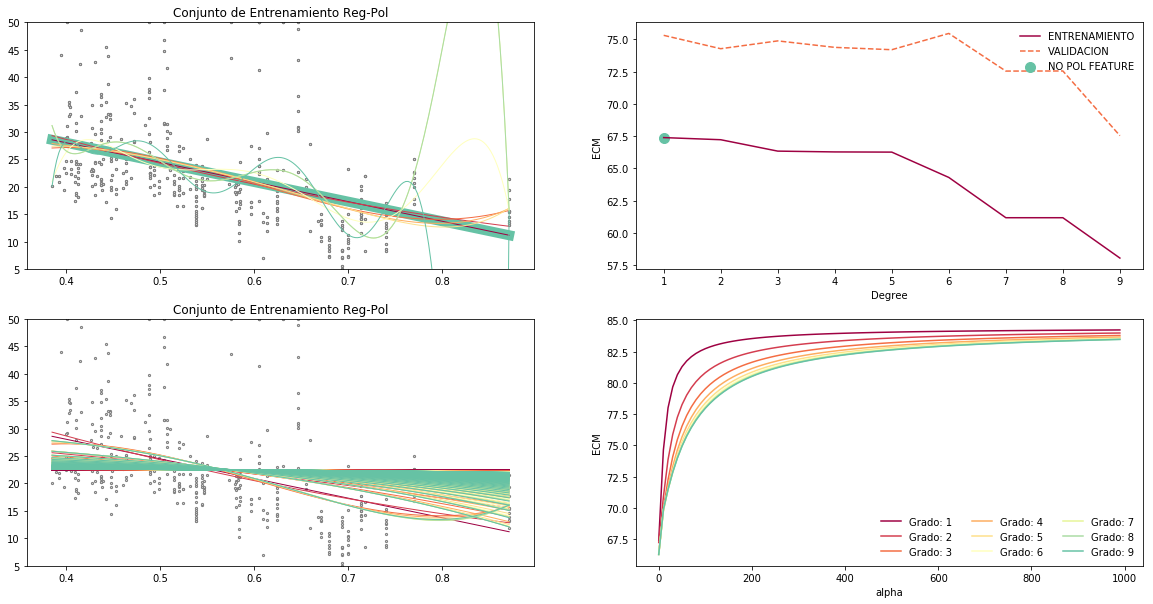

RM


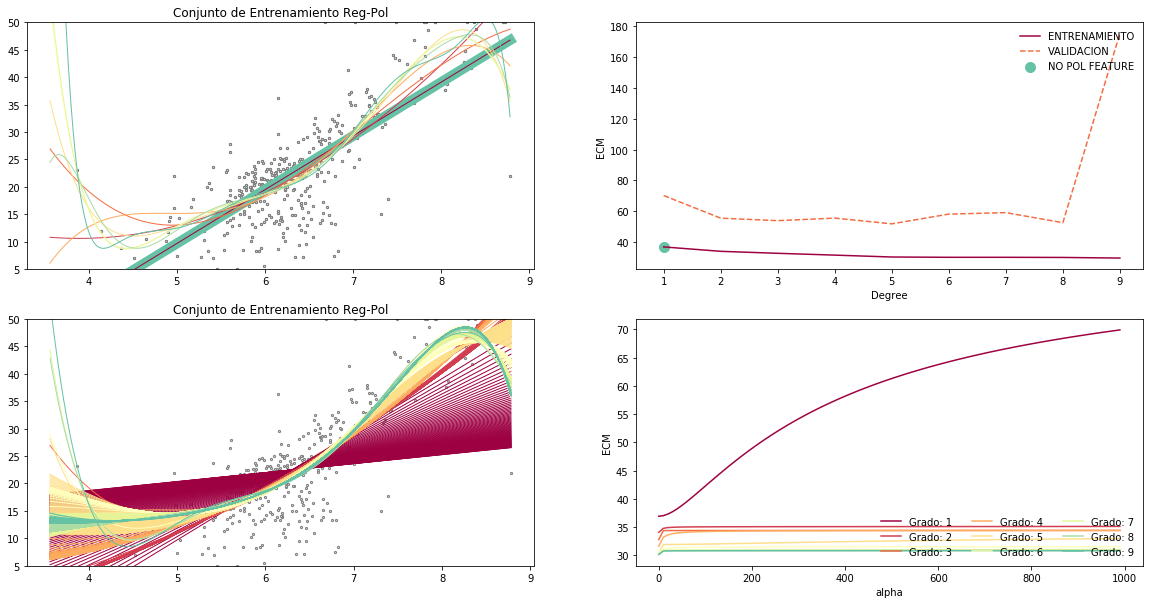

INDUS


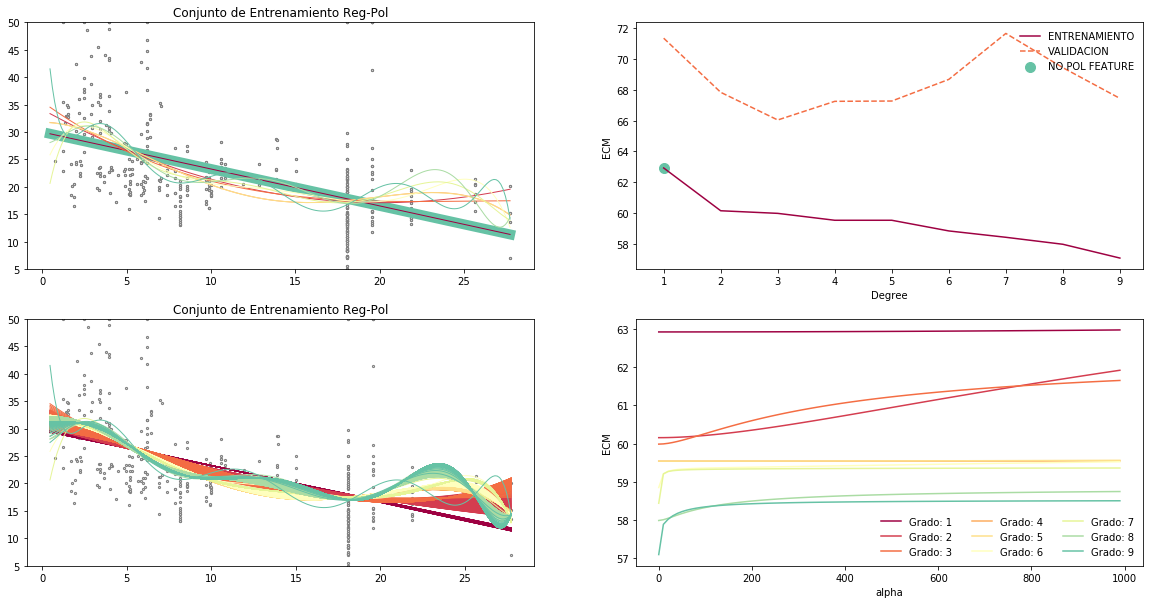

B


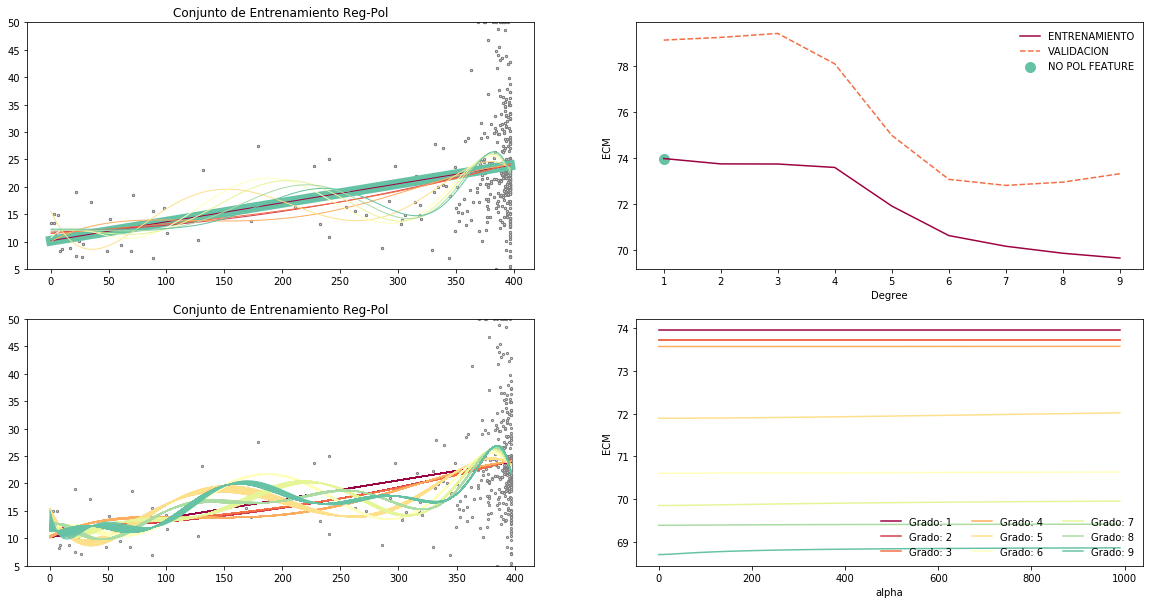

LSTAT


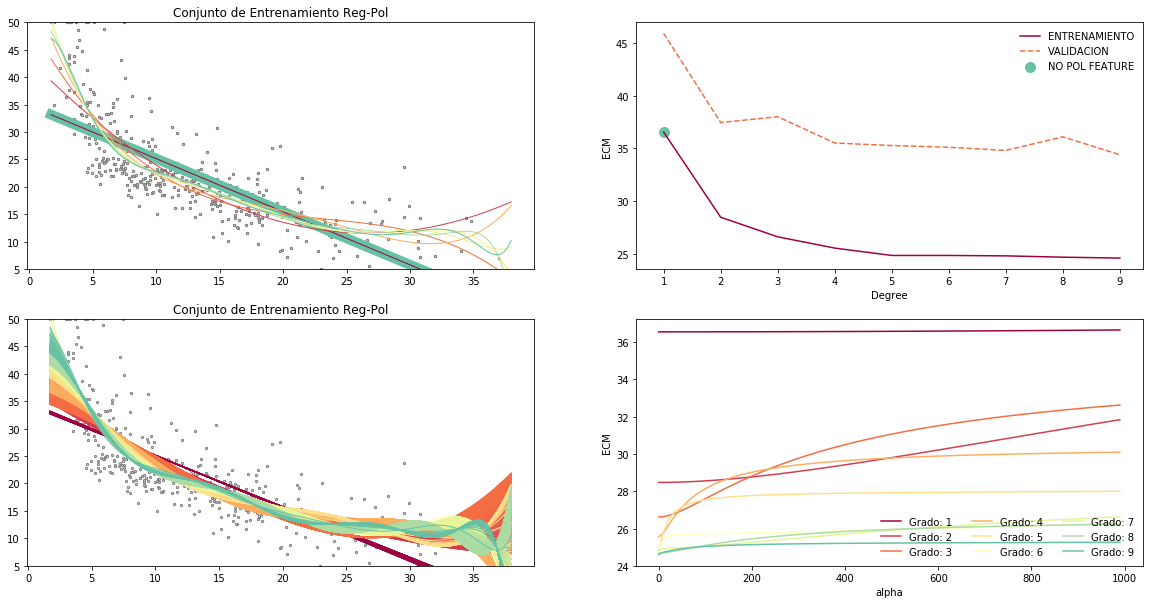

DIS


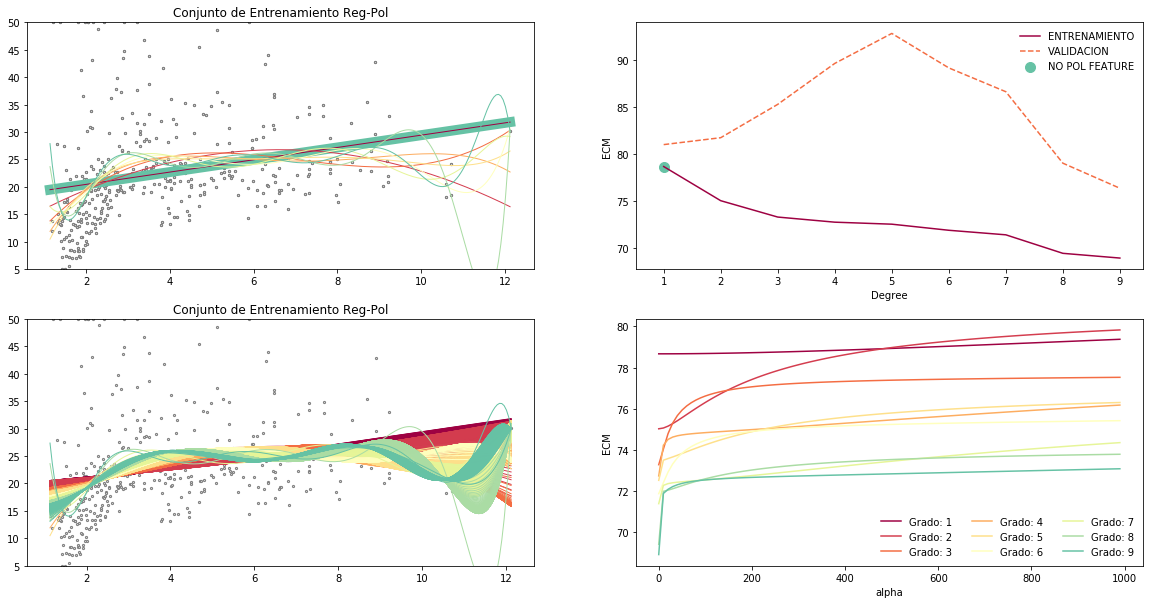

PTRATIO


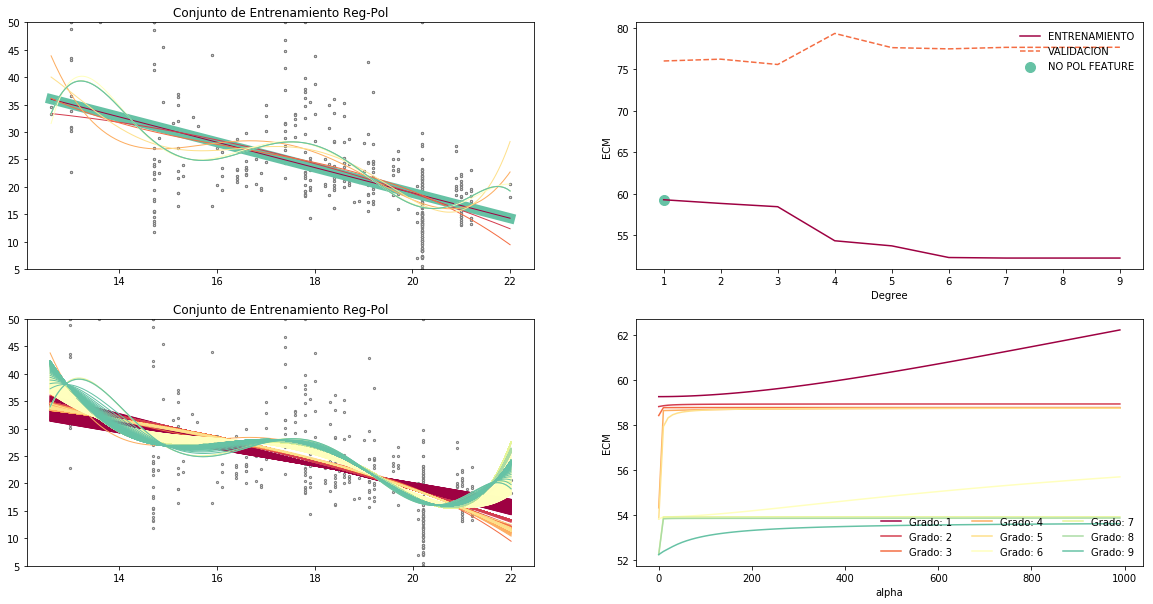

In [9]:
diferencias=[]
for feature in non_categorical_features:
    print(feature)
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    plt.figure(figsize=(20,10))
    
    feature_resultadosl = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                               (regresion_lineal_ECM.Regularization==False)]
    punto_err_metodo_lineal = [1,feature_resultadosl.TrainMSE.values[0]]
    
    #plt.subplot(421)
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==False)]
    plt.subplot(221)
    plot_fit(feature_resultadosl,'L',color[-1],lw=10)
    plot_fit(feature_resultados,'P',color,lw=1)
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Alpha==0)&
                                                  (regresion_polinomial_ECM.Feature==feature)]

    diferencias.append(punto_err_metodo_lineal[1]-feature_resultados.TrainMSE.values[0])
    
    plt.subplot(222)
    plot_err_g(feature_resultados,'T',color[0])
    plot_err_g(feature_resultados,'V',color[2])
    plt.scatter(punto_err_metodo_lineal[0],punto_err_metodo_lineal[1],color=color[-1],s=100,label='NO POL FEATURE')
    plt.legend(frameon=False,loc='upper right')
    
    
    
    feature_resultados = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                             (regresion_lineal_ECM.Regularization==True)]
    
    #plt.subplot(323)
    #plot_fit(feature_resultados,'L',color[0],lw=1)
    #plt.subplot(324)
    #plot_err(feature_resultados,'L',color[0])
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==True)]
    plt.subplot(223)
    plot_fit(feature_resultados,'P',color,lw=1)
    plt.subplot(224)
    plot_err(feature_resultados,'T','P',color)
    #plot_err(feature_resultados,'V','P',color)
    
    plt.show()

In [25]:
breast_cancer_data = load_breast_cancer()

In [26]:
# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(569)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = breast_cancer_data['data'][shuff_train]
X_val = breast_cancer_data['data'][shuff_val]

y_train = breast_cancer_data['target'][shuff_train]
y_val = breast_cancer_data['target'][shuff_val]


data = pd.DataFrame(breast_cancer_data['data'],columns=breast_cancer_data['feature_names'])
data['cancer_label'] = breast_cancer_data['target']
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,cancer_label
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


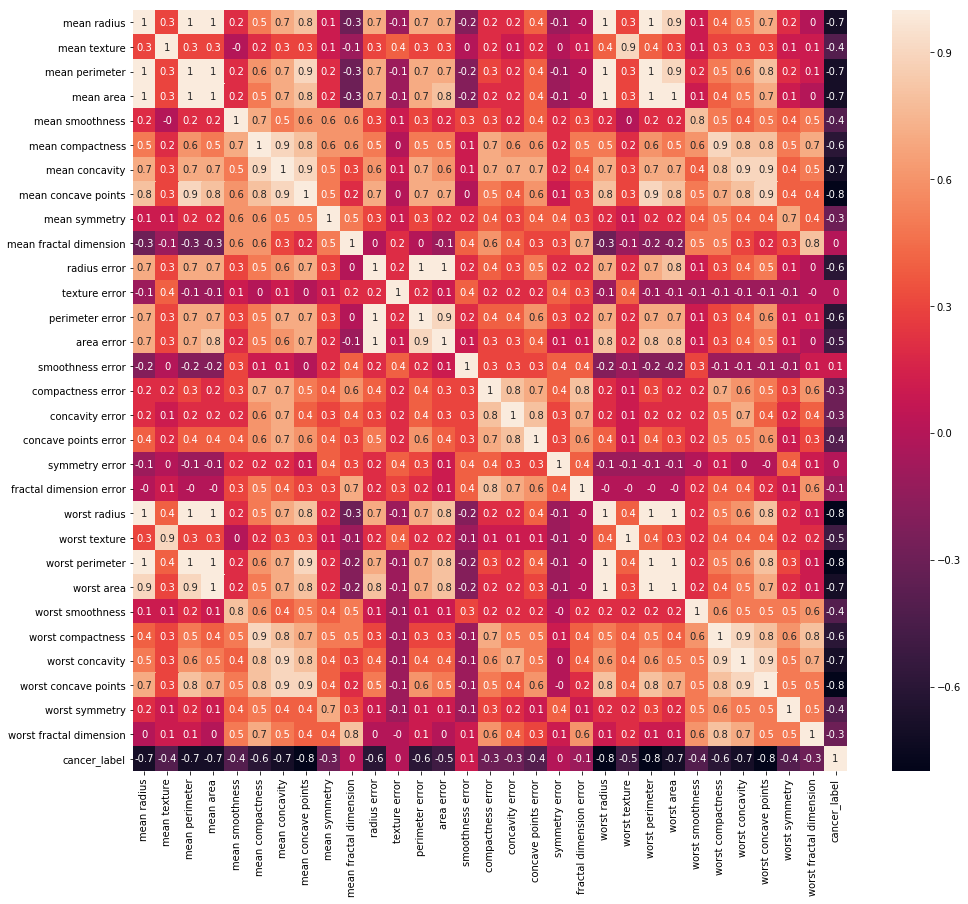

In [27]:
import seaborn as sb

correlation_matrix = data.corr().round(1)
fig, ax = plt.subplots(figsize=(16,14))
sb.heatmap(data=correlation_matrix, annot = True)


In [28]:
features_original = breast_cancer_data['feature_names']

In [34]:
features = []
for f in features_original:
    if 'error' in f: continue
    features.append(f)

In [35]:
features

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [45]:
feature_map = {feature: idx for idx, feature in enumerate(features)}
e4 = 'verdaderos_positivos'
e3 = 'falsos_positivos'
e2 = 'falsos_negativos'
e1 = 'verdaderos_negativos'

penalties = ['None','l1','l2', 'elasticnet']

iterations = [10,100,1000]
alphas = [1e-5,1e-3,1e-1,1e1]
columnas = ['fx','fy','penalty','alpha','iter','ee','ev',e1,e2,e3,e4]
dtCB = pd.DataFrame(columns=columnas)


for fx in features:
    x_feature = fx 
    print('\n\n\n\n******** ',x_feature)
    for fy in list(set(features)-set([fx])):
        print('-',fy)
        y_feature = fy
        
        x_feature_col = feature_map[x_feature]
        y_feature_col = feature_map[y_feature]
        X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
        X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

        for p in penalties:
            penalty = p
            for a in alphas:
                alpha = a
                for it in iterations:
                    max_iter = it
            
                    model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
                    model.fit(X_train_feature, y_train)
            
                    ee=accuracy_score(y_train, model.predict(X_train_feature))
                    ev=accuracy_score(y_val, model.predict(X_val_feature))
                    #print('Exactitud para entrenamiento: %.2f' %  ee)
                    #print('Exactitud para validación: %.2f' % ev)
                    
                    matriz = confusion_matrix(y_train, model.predict(X_train_feature))
                               
                    dtCB = dtCB.append({'fx':fx,'fy':fy,'penalty':penalty,'alpha':alpha,'iter':max_iter,
                                        'ee':ee,'ev':ev,e1:matriz[0][0],e2:matriz[0][1],
                                        e3:matriz[1][0],e4:matriz[1][1]},ignore_index=True)





********  mean radius
- mean smoothness
- worst symmetry
- mean compactness
- worst texture
- mean perimeter
- worst concave points
- mean concavity
- mean fractal dimension
- worst radius
- worst compactness
- worst concavity
- worst perimeter
- mean symmetry
- mean texture
- worst smoothness
- worst area
- worst fractal dimension
- mean concave points
- mean area




********  mean texture
- mean smoothness
- worst symmetry
- mean compactness
- worst texture
- mean perimeter
- worst concave points
- mean concavity
- mean fractal dimension
- mean radius
- worst radius
- worst compactness
- worst concavity
- worst perimeter
- mean symmetry
- worst smoothness
- worst area
- worst fractal dimension
- mean concave points
- mean area




********  mean perimeter
- mean smoothness
- worst symmetry
- mean compactness
- worst texture
- worst concave points
- mean concavity
- mean fractal dimension
- mean radius
- worst radius
- worst compactness
- worst concavity
- worst perimeter
- mean 

In [46]:
dtCB

,fx,fy,penalty,alpha,iter,ee,ev,verdaderos_negativos,falsos_negativos,falsos_positivos,verdaderos_positivos
0,mean radius,mean smoothness,None,0.00001,10,0.3675,0.390533,146,0,253,1
1,mean radius,mean smoothness,None,0.00001,100,0.7750,0.781065,138,8,82,172
2,mean radius,mean smoothness,None,0.00001,1000,0.8350,0.863905,130,16,50,204
3,mean radius,mean smoothness,None,0.00100,10,0.3675,0.390533,146,0,253,1
4,mean radius,mean smoothness,None,0.00100,100,0.7750,0.781065,138,8,82,172
5,mean radius,mean smoothness,None,0.00100,1000,0.8350,0.863905,130,16,50,204
6,mean radius,mean smoothness,None,0.10000,10,0.3675,0.390533,146,0,253,1
7,mean radius,mean smoothness,None,0.10000,100,0.7750,0.781065,138,8,82,172
8,mean radius,mean smoothness,None,0.10000,1000,0.8350,0.863905,130,16,50,204
9,mean radius,mean smoothness,None,10.00000,10,0.3675,0.390533,146,0,253,1


In [47]:
dtCB.to_csv(r'clasificacion_cancer.csv',index=None,header=True,sep='|')

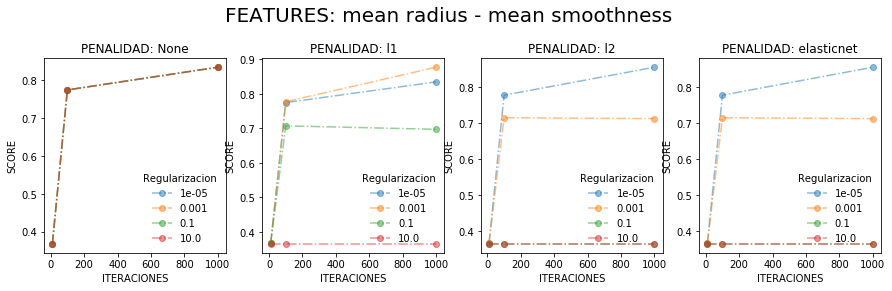

In [140]:
fig=plt.figure(figsize=(15,4))
fx = 'mean radius'
fy = 'mean smoothness'

fig.suptitle('FEATURES: '+fx+' - '+fy , fontsize=20)
j=1
ls=['--',':','-.','-']


for p in penalties:
    plt.subplot(1,4,j)
    sub=dtCB[(dtCB.penalty==p)&(dtCB.fx==fx)&(dtCB.fy==fy)]
    for a in alphas:
        plt.plot(sub[sub.alpha==a].iter.values,sub[sub.alpha==a].ee.values,label=str(a),marker='o',ls='-.',alpha=0.5)
    plt.legend(title='Regularizacion',frameon=False,loc='lower right')
    plt.title('PENALIDAD: ' + p)
    plt.xlabel('ITERACIONES')
    plt.ylabel('SCORE')
    j+=1

plt.subplots_adjust(wspace=0.2, top=0.8)

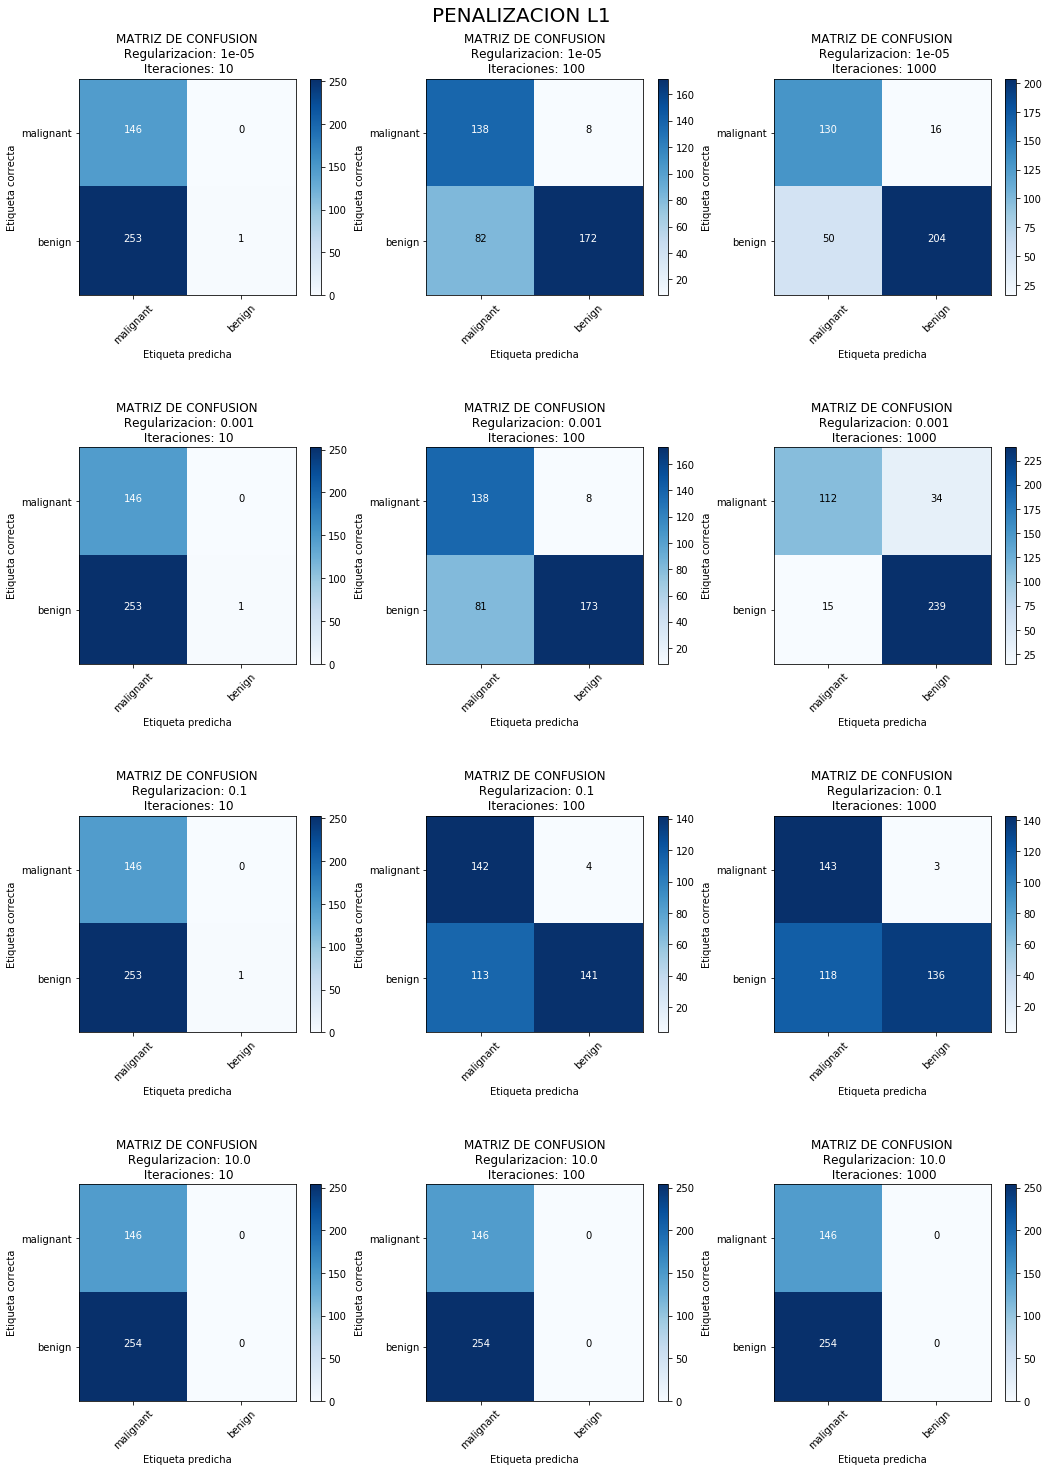

In [145]:
sub=dtCB[(dtCB.penalty=='l1')&(dtCB.fx==fx)&(dtCB.fy==fy)]
fig = plt.figure(figsize=(15,20))
fig.suptitle('PENALIZACION L1', fontsize=20)
for i in range(len(sub)):
    plt.subplot(4,3,i+1)
    matriz=np.array([[sub.verdaderos_negativos.values[i],sub.falsos_negativos.values[i]],
        [sub.falsos_positivos.values[i],sub.verdaderos_positivos.values[i]]])
    plot_confusion_matrix(matriz,classes=breast_cancer_data.target_names,
    title='MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i]))
plt.subplots_adjust( wspace=0.2, top=0.93, hspace=0.7)

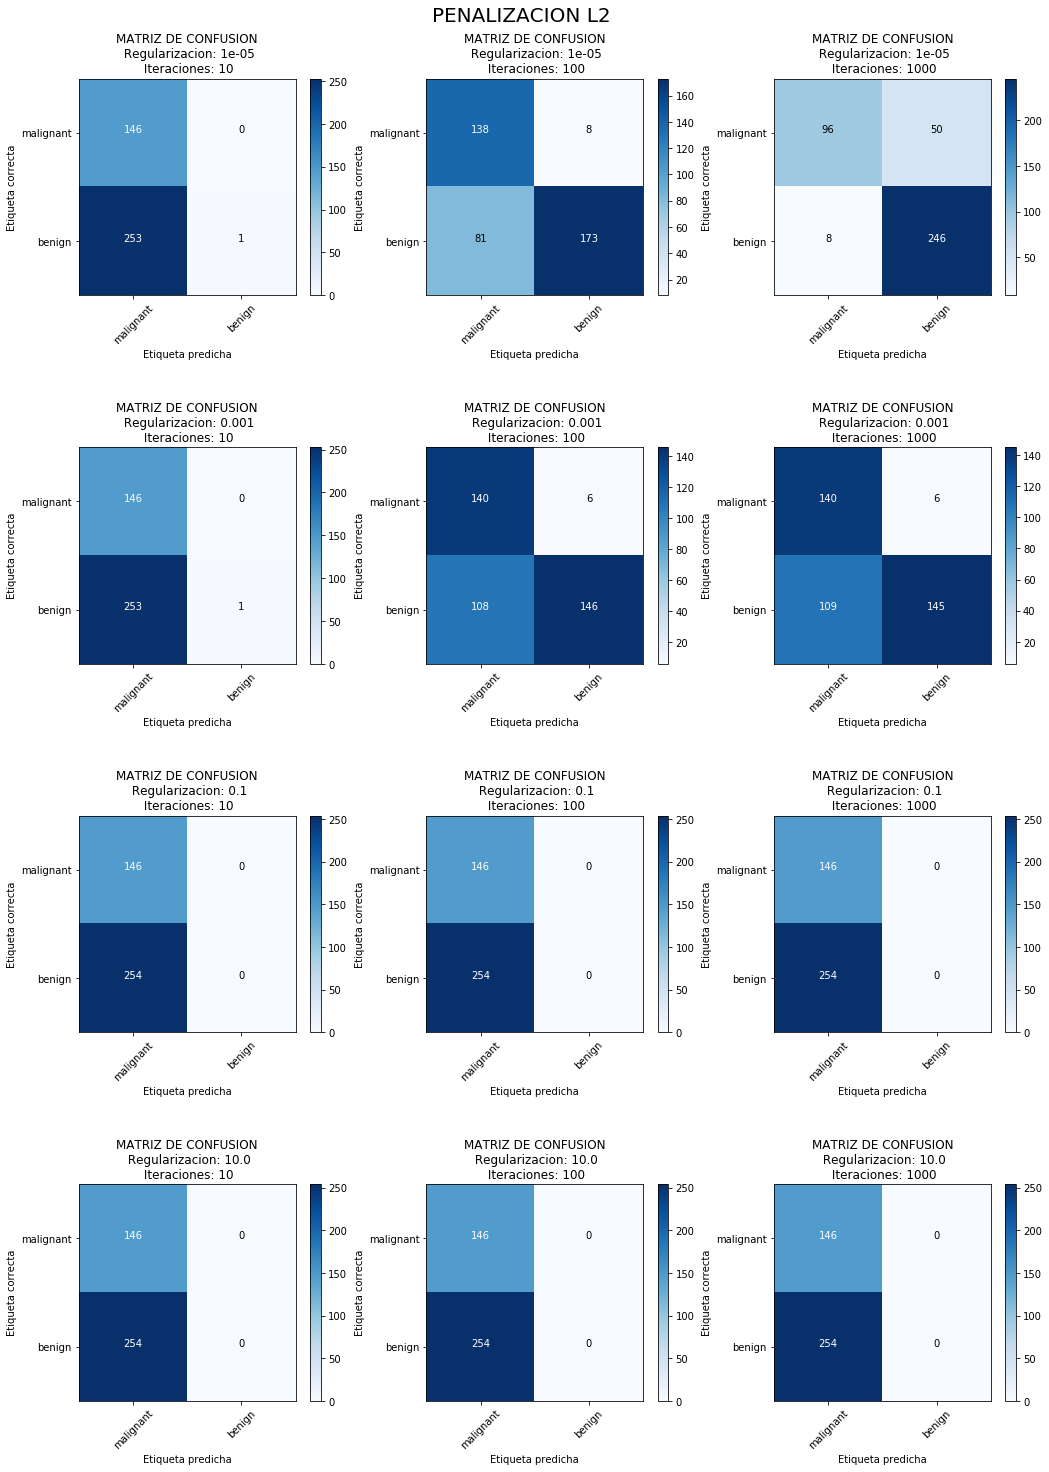

In [147]:
sub=dtCB[(dtCB.penalty=='l2')&(dtCB.fx==fx)&(dtCB.fy==fy)]
fig = plt.figure(figsize=(15,20))
fig.suptitle('PENALIZACION L2', fontsize=20)
for i in range(len(sub)):
    plt.subplot(4,3,i+1)
    matriz=np.array([[sub.verdaderos_negativos.values[i],sub.falsos_negativos.values[i]],
        [sub.falsos_positivos.values[i],sub.verdaderos_positivos.values[i]]])
    plot_confusion_matrix(matriz,classes=breast_cancer_data.target_names,
    title='MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i])) 
plt.subplots_adjust( wspace=0.2, top=0.93, hspace=0.7)

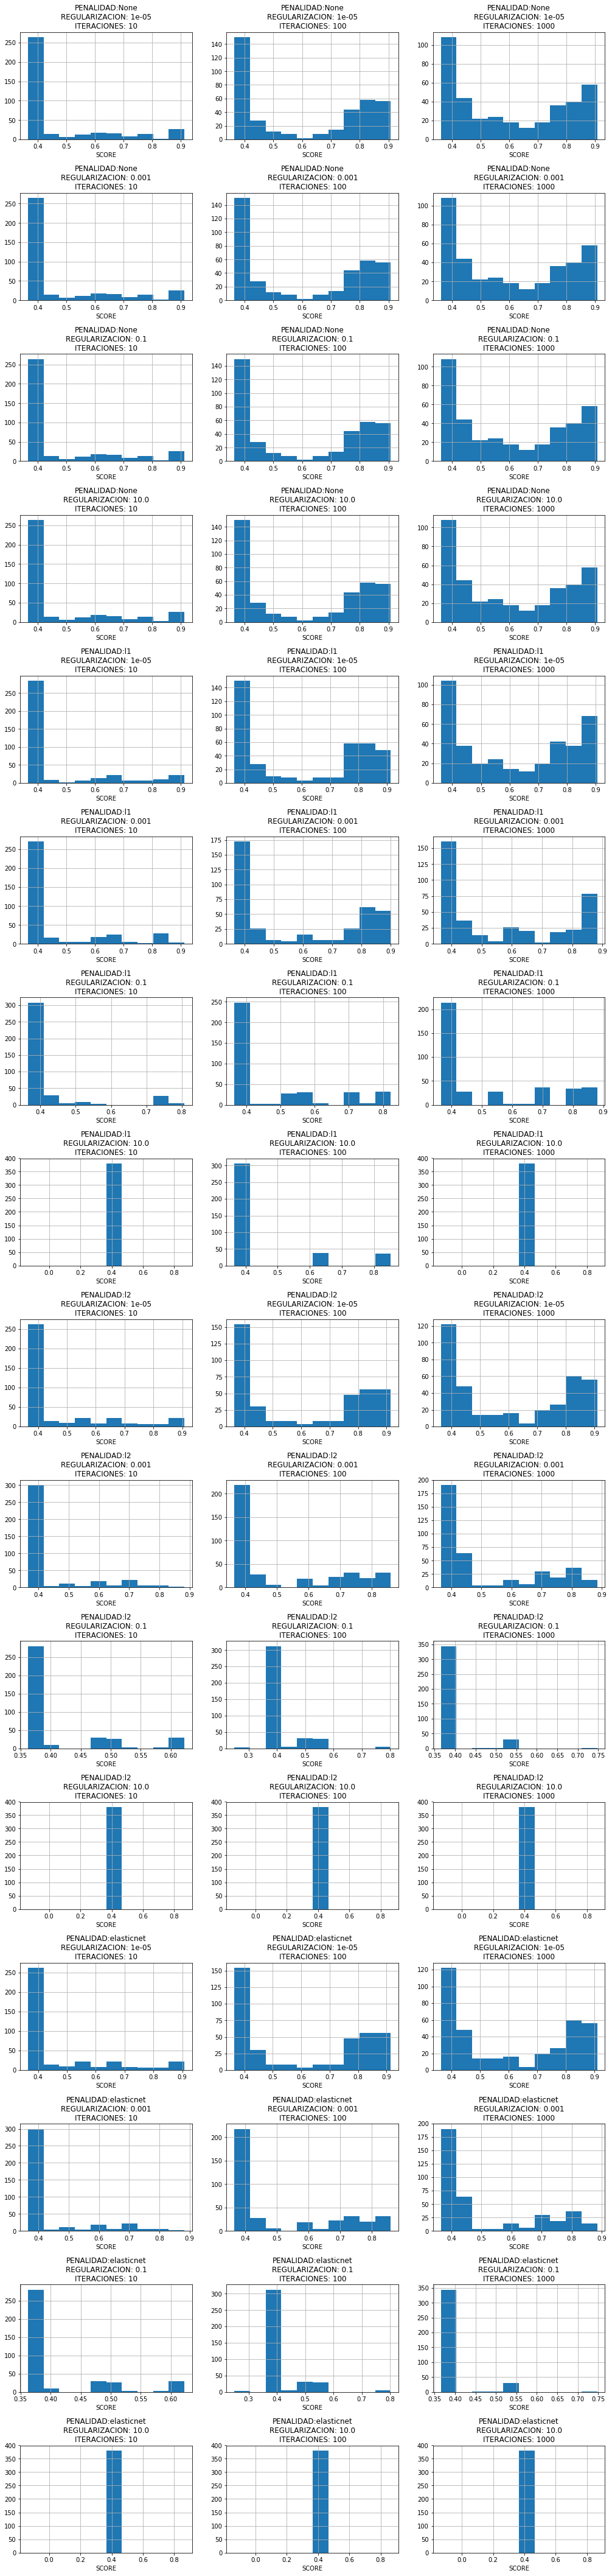

In [125]:
fig = plt.figure(figsize=(15,20))
j=1
for p in penalties:
    for a in alphas:
        for i in iterations:
            plt.subplot(16,3,j)
            dtCB[(dtCB.iter==i)&(dtCB.penalty==p)&(dtCB.alpha==a)].ee.hist()
            #plt.title('MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i])
            plt.title('PENALIDAD:'+str(p)+'\nREGULARIZACION: '+str(a)+'\nITERACIONES: '+str(i))
            plt.xlabel('SCORE')
            j+=1
            
plt.subplots_adjust(left=0.01, wspace=0.2, top=3, hspace=0.5)            

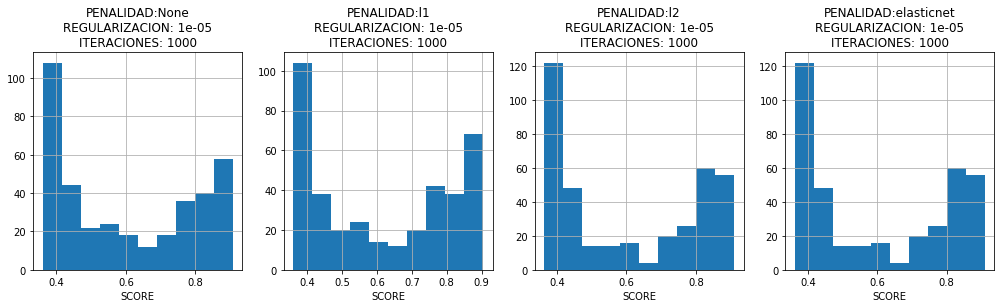

In [126]:
fig = plt.figure(figsize=(15,4))
j=1
for p in penalties:
    plt.subplot(1,4,j)
    dtCB[(dtCB.iter==1000)&(dtCB.penalty==p)&(dtCB.alpha==1e-5)].ee.hist()
    #plt.title('MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i])
    plt.title('PENALIDAD:'+str(p)+'\nREGULARIZACION: '+str(1e-5)+'\nITERACIONES: '+str(1000))
    plt.xlabel('SCORE')
    j+=1
            
plt.subplots_adjust(left=0.01, wspace=0.2)     

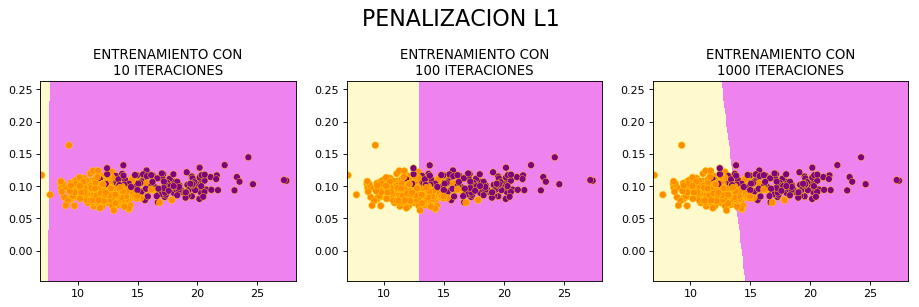

In [182]:
x_feature = fx
y_feature = fy

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

penalty = 'l1'
alpha = 1e-5 
j=1

fig=plt.figure(figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('PENALIZACION L1', fontsize=20)
for i in iterations:
    max_iter = i
    model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
    model.fit(X_train_feature, y_train)
    
    xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)
    
    cmap_dots = ListedColormap(['purple', 'darkorange'])
    cmap_edge = ListedColormap(['darkviolet', 'gold'])
    cmap_back = ListedColormap(['violet', 'lemonchiffon'])
    
    # Conjunto de entrenamiento
    plt.subplot(1, 3,j)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
    plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='gold',lw=0.4, s=38)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('ENTRENAMIENTO CON\n'+str(i)+' ITERACIONES')
    
    j+=1
plt.subplots_adjust( top=0.75)    